<a href="https://colab.research.google.com/github/hislam000/CSC-599.70-Course-Project/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Intro to Data Science, Fall 2019 @ CCNY
# CSC-599.70-Course-Project
# Final-Project
# Team Member & Name: RentAdvisor (3-Member)

# ABDUR RAFEY
# HASIBUL ISLAM
# DZHONIBEK PARMANKULOV

In [0]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import warnings
%matplotlib inline

In [0]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
submit1_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)

In [20]:
train_df.sample(5)

,addr_unit,building_id,bedrooms,bathrooms,size_sqft,created_at,addr_street,addr_city,addr_zip,addr_lat,addr_lon,bin,bbl,floor_count,year_built,min_to_subway,has_doorman,has_elevator,has_fireplace,has_dishwasher,is_furnished,has_gym,allows_pets,has_washer_dryer,has_garage,has_roofdeck,has_concierge,has_pool,has_garden,has_childrens_playroom,rent,no_fee,description,neighborhood,borough,unit,floornumber,line
rental_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7291084,#2,1256671,1,1.0,600.0,2018-06-20 14:06:52,14-31 28 AVENUE,Astoria,11102,40.771757,-73.927645,4006077.0,4005390007,4.0,2013.0,6.7833,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2400,0,This beautiful one-bedroom has beautiful cherr...,Astoria,Queens,2,2.0,NaN
7401403,#3D,135256,1,1.0,750.0,2018-07-25 13:18:33,56 NORTH 9 STREET,Brooklyn,11249,40.721056,-73.960381,3425621.0,3023090005,6.0,2018.0,4.3167,0,1,0,1,0,1,1,1,1,1,0,0,0,0,3150,1,"Located in the heart of Williamsburg, 56N9 is ...",Williamsburg,Brooklyn,3D,3.0,D
7145041,#2,165301,2,1.0,850.0,2018-05-03 23:12:23,506 PRESIDENT STREET,Brooklyn,11215,40.677719,-73.986524,3007491.0,3004470026,2.0,1899.0,1.6667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2500,1,Large Light filled 2 bed 1 bath on sweet block...,Gowanus,Brooklyn,2,2.0,NaN
7411129,#1RNN,15763,1,1.0,600.0,2018-07-26 10:18:12,215 AVENUE A,New York,10009,40.730099,-73.980953,1083483.0,1004410033,5.0,1880.0,1.8667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2300,0,Brand New 1BR apt located on 13th Street Ave ...,East Village,Manhattan,1RNN,1.0,RNN
7312189,#1B,643183,1,1.0,750.0,2018-06-27 14:01:08,268 72 STREET,Brooklyn,11209,40.633443,-74.027627,3147298.0,3059070036,3.0,1926.0,2.6667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1600,0,Apartment Specs:\r\n\r\n-New Hardwood floors\r...,Bay Ridge,Brooklyn,1B,1.0,B


In [0]:
# extract usable features
feature_cols = [
    'bedrooms', 'year_built', 'bathrooms', 'min_to_subway', 
    'size_sqft', 'no_fee', 'has_doorman',
    'addr_zip','floor_count',#'has_elevator',#'has_dishwasher',	#'is_furnished',	
    'has_gym','allows_pets',#'has_garage',
    'has_concierge',#'has_pool',#'has_garden',	
    #the reason of commenting out certain feature is because they are increasing mean squared error
]
train_features = train_df[feature_cols] 

# impute missing values with medians
train_features = train_features.fillna(train_features.median(), axis=0)

# construct target vector
train_target = train_df['rent']

In [22]:
# using linear regression method
lreg = LinearRegression()
lreg.fit(train_features, train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
test_features = test_df[feature_cols] 

# impute missing values with medians
test_features = test_features.fillna(train_features.median(), axis=0)

# construct predictions 
test_df['predicted'] = lreg.predict(test_features)
print("Prediction using Linear Regression train data against Test1:")

print("Mean Squared Error for Test1 using Linear Regression:",mean_squared_error(test_df['rent'], test_df['predicted']))

Prediction using Linear Regression train data against Test1:
Mean Squared Error for Test1 using Linear Regression: 3313817.143868871


In [24]:
rf = RandomForestRegressor()
rf.fit(train_features, train_target)

# construct predictions 
test_df['predicted'] = rf.predict(test_features)
print("Prediction using Random Forest Regressor train data against Test1:")
print("Mean Squared Error for Test1 using Random Forest Regressor:",mean_squared_error(test_df['rent'], test_df['predicted']))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Prediction using Random Forest Regressor train data against Test1:
Mean Squared Error for Test1 using Random Forest Regressor: 1910126.5956812615


In [25]:
#joining training data and test1 data to incredase total training data
master_df = train_df.append(test_df, sort=False)

master_features = master_df[feature_cols].fillna(master_df[feature_cols].median(), axis=0)
master_target = master_df['rent']
#linear regression
#lreg.fit(master_features, master_target)

#Random Forest Regressor
rf.fit(master_features, master_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [26]:
#handling missing data
submit1_features = submit1_df[feature_cols].fillna(master_df[feature_cols].median(), axis=0)
submit1_features.sample(10)

,bedrooms,year_built,bathrooms,min_to_subway,size_sqft,no_fee,has_doorman,addr_zip,floor_count,has_gym,allows_pets,has_concierge
rental_id,,,,,,,,,,,,
7442212,0,2000.0,1.0,6.9167,522.0,1,1,10019,12.0,1,1,1
7516396,1,2014.0,1.0,2.7667,750.0,1,1,10018,0.0,1,1,1
7446763,1,1926.0,1.0,3.7000,650.0,0,0,10016,4.0,0,1,0
7510654,1,1931.0,1.0,3.5500,650.0,0,0,11204,2.0,0,0,0
7460761,1,1936.0,1.0,1.9500,500.0,0,0,11209,4.0,0,0,0
7492324,0,1900.0,1.0,2.4833,1100.0,0,0,10013,7.0,0,0,0
7485187,2,1929.0,1.0,3.5000,750.0,0,0,11105,4.0,0,0,0
7463689,3,1930.0,1.0,4.5833,1100.0,1,0,11385,3.0,0,0,0
7458628,3,1905.0,1.0,3.5333,900.0,1,0,11221,3.0,0,1,0


In [0]:
#submit1_features = submit1_df[feature_cols].fillna(submit1_df[feature_cols].median(), axis=0)
submit1_df['rent'] = rf.predict(submit1_features)
submit1_df['rent'].to_csv('test2.csv', header=True)

#these part has to be changed
#submit1_df['median_rent'] = np.ones(submit1_df['rent'].shape) * master_target.median()
#print("Prediction of rent for Test2")
#print("Mean Squared error for Test2: ",mean_squared_error(submit1_df['rent'], submit1_df['median_rent']))

In [30]:
submit1_df['rent'].sample(10)

rental_id
7508881     3974.00
7503040     2442.30
7506787     2791.40
7521037     3295.00
7485433    19990.00
7492051     2859.20
7441156     3336.14
7480063     4137.90
7438501     2870.90
7462309     3674.70
Name: rent, dtype: float64

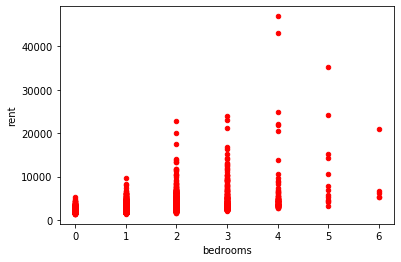

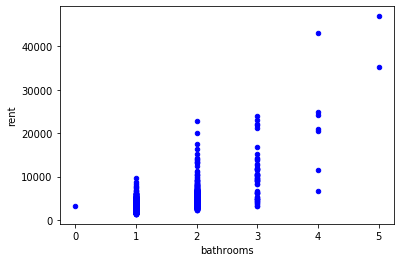

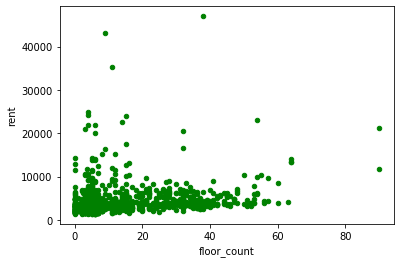

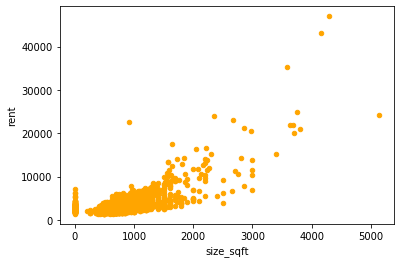

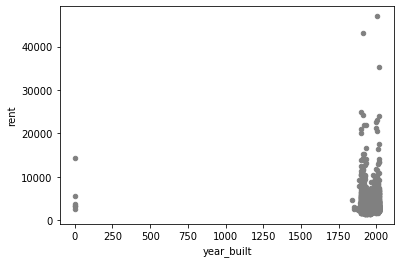

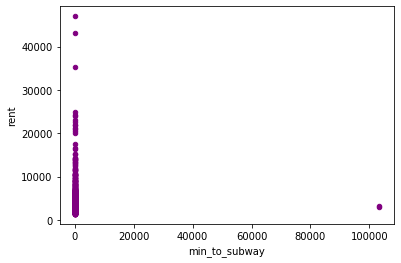

In [31]:
# Scatter plots of different features for test2 data: 

submit1_df.plot(kind='scatter',x='bedrooms',y='rent',color='red')
plt.show()

submit1_df.plot(kind='scatter',x='bathrooms',y='rent',color='blue')
plt.show()

submit1_df.plot(kind='scatter',x='floor_count',y='rent',color='green')
plt.show()

submit1_df.plot(kind='scatter',x='size_sqft',y='rent',color='orange')
plt.show()

submit1_df.plot(kind='scatter',x='year_built',y='rent',color='gray')
plt.show()

submit1_df.plot(kind='scatter',x='min_to_subway',y='rent',color='purple')
plt.show()

#lines = submit1_df.plot.line(x='bedrooms',y='rent')

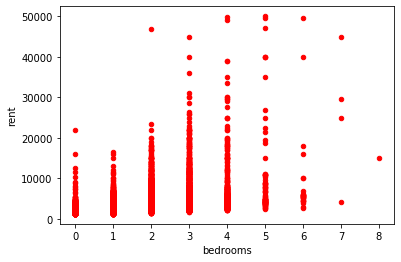

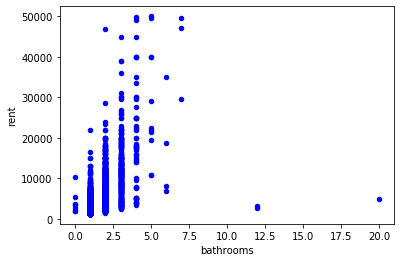

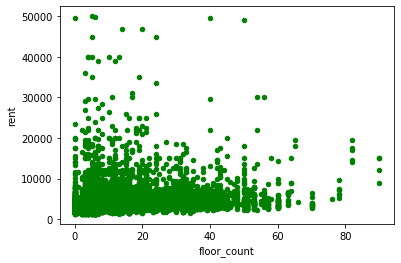

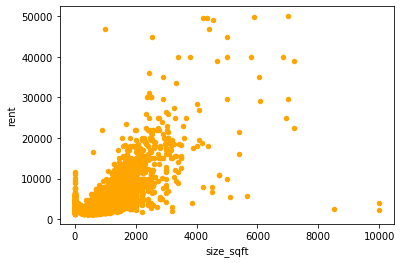

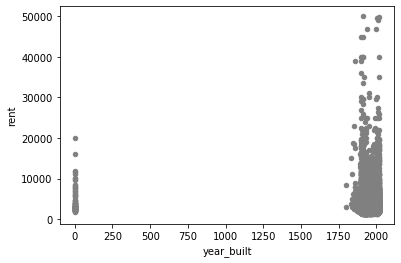

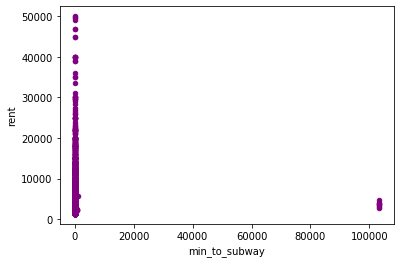

In [32]:
# Scatter plots of different features for training data: 

master_df.plot(kind='scatter',x='bedrooms',y='rent',color='red')
plt.show()

master_df.plot(kind='scatter',x='bathrooms',y='rent',color='blue')
plt.show()

master_df.plot(kind='scatter',x='floor_count',y='rent',color='green')
plt.show()

master_df.plot(kind='scatter',x='size_sqft',y='rent',color='orange')
plt.show()

master_df.plot(kind='scatter',x='year_built',y='rent',color='gray')
plt.show()

master_df.plot(kind='scatter',x='min_to_subway',y='rent',color='purple')
plt.show()




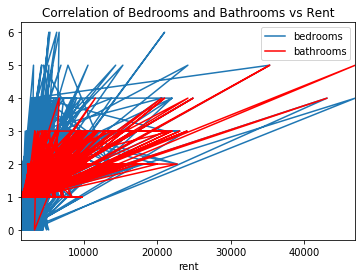

In [33]:
ax = plt.gca()
submit1_df.plot(kind='line',x='rent',y='bedrooms',title='Correlation of Bedrooms and Bathrooms vs Rent',ax=ax)
submit1_df.plot(kind='line',x='rent',y='bathrooms', color='red', ax=ax)
#submit1_df.plot(kind='line',x='rent',y='floornumber', color='green', ax=ax)
plt.show()

In [34]:
#OLS Regression Results for Testing2 Data
# Add a constant to our existing dataframe for modeling purposes
submit1_df = sm.add_constant(submit1_df)

est = sm.OLS(submit1_df['rent'], 
             submit1_features[['bedrooms', 'year_built', 'bathrooms', 'min_to_subway','size_sqft', 'no_fee', 'has_doorman','addr_zip','floor_count','has_gym','allows_pets']]
            ).fit()

print(est.summary())



                                 OLS Regression Results                                
Dep. Variable:                   rent   R-squared (uncentered):                   0.873
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                              1239.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):                        0.00
Time:                        20:19:25   Log-Likelihood:                         -17606.
No. Observations:                2000   AIC:                                  3.523e+04
Df Residuals:                    1989   BIC:                                  3.530e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [35]:
#OLS Regression Results for Trainin Data
# Add a constant to our existing dataframe for modeling purposes
master_df = sm.add_constant(master_df)

est = sm.OLS(master_df['rent'], 
             master_features[['bedrooms', 'year_built', 'bathrooms', 'min_to_subway','size_sqft', 'no_fee', 'has_doorman','addr_zip','floor_count','has_gym','allows_pets']]
            ).fit()

print(est.summary())


                                 OLS Regression Results                                
Dep. Variable:                   rent   R-squared (uncentered):                   0.836
Model:                            OLS   Adj. R-squared (uncentered):              0.836
Method:                 Least Squares   F-statistic:                              6487.
Date:                Thu, 05 Dec 2019   Prob (F-statistic):                        0.00
Time:                        20:19:34   Log-Likelihood:                     -1.2528e+05
No. Observations:               14000   AIC:                                  2.506e+05
Df Residuals:                   13989   BIC:                                  2.507e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
